In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import datetime

In [3]:
raw_data = pd.read_csv("../Data/jena_climate_2009_2016.csv")

In [4]:
raw_data

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [5]:
raw_data["Date Time"] = pd.to_datetime(raw_data["Date Time"],format="%d.%m.%Y %H:%M:%S")
raw_data.set_index("Date Time",inplace=True)

<ipython-input-6-94fa21e41fb2>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  raw_data["2009":"2010"]["Tdew (degC)"].plot(figsize=(25,6))


<AxesSubplot:xlabel='Date Time'>

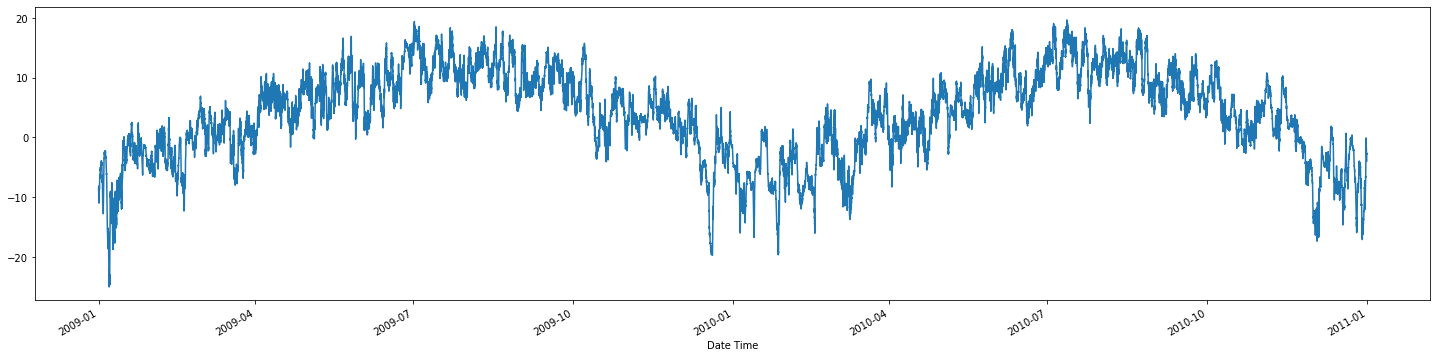

In [6]:
raw_data["2009":"2010"]["Tdew (degC)"].plot(figsize=(25,6))

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """Turns a timeseries into a supervised series
    which can be used with supvervised learning methods

    Args:
        data ([type]): Usually a dataframe
        n_in (int, optional): Lag of the input. Defaults to 1.
        n_out (int, optional): how many Timesteps forecast into the future. Defaults to 1.
        dropnan (bool, optional): Drop rows that contain NaN values. Defaults to True.

    Returns:
        Dataframe: Dataframe with lag and output
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{}(t-{})'.format(data.columns[j], i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{}(t)'.format(data.columns[j]))
                      for j in range(n_vars)]
        else:
            names += [('{}(t+{})'.format(data.columns[j], i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
df = raw_data.copy()
lag_steps = 6 * 24
forecast_steps = 6 * 12

df = df[["T (degC)", "H2OC (mmol/mol)", "Tdew (degC)"]]["2009" : "2011"]
df = series_to_supervised(df,lag_steps,forecast_steps)

<ipython-input-8-9ab51731de34>:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df[["T (degC)", "H2OC (mmol/mol)", "Tdew (degC)"]]["2009" : "2011"]


In [9]:
n_X = int(len(df.index)*0.8)
X_train = df.filter(regex='\-')[:n_X]
y_train = df[df.columns.drop(list(df.filter(regex='\-')))][:n_X].filter(regex="T \(degC\)\(t\+")
X_test = df.filter(regex='\-')[n_X:]
y_test = df[df.columns.drop(list(df.filter(regex='\-')))][n_X:].filter(regex="T \(degC\)\(t\+")

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(126084, 432) (126084, 71) (31522, 432) (31522, 71)


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

regression_model = LinearRegression()
regression_model.fit(X_train,y_train)
y_pred = regression_model.predict(X_test)

knn_model = KNeighborsRegressor()
knn_model.fit(X_train,y_train)
y_pred_knn = knn_model.predict(X_test)

dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train,y_train)
y_pred_dtr = dtr_model.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Linear Regression:")
print('   Mean squared error: %.2f'% mean_squared_error(y_test, y_pred))
print('   Mean absolute error: %.2f'% mean_absolute_error(y_test, y_pred))
#print('   Mean absolute percentage error: %.2f'% mean_absolute_percentage_error(y_test, y_pred))
print('   Coefficient of determination: %.2f'% r2_score(y_test, y_pred))

print("K-Nearest-Neighbor:")
print('   Mean squared error: %.2f'% mean_squared_error(y_test, y_pred_knn))
print('   Mean absolute error: %.2f'% mean_absolute_error(y_test, y_pred_knn))
#print('   Mean absolute percentage error: %.2f'% mean_absolute_percentage_error(y_test, y_pred_knn))
print('   Coefficient of determination: %.2f'% r2_score(y_test, y_pred_knn))


print("Decision-Tree-Regressor:")
print('   Mean squared error: %.2f'% mean_squared_error(y_test, y_pred_dtr))
print('   Mean absolute error: %.2f'% mean_absolute_error(y_test, y_pred_dtr))
#print('   Mean absolute percentage error: %.2f'% mean_absolute_percentage_error(y_test, y_pred_dtr))
print('   Coefficient of determination: %.2f'% r2_score(y_test, y_pred_dtr))

Linear Regression:
   Mean squared error: 6.07
   Mean absolute error: 1.74
   Coefficient of determination: 0.89
K-Nearest-Neighbor:
   Mean squared error: 12.65
   Mean absolute error: 2.71
   Coefficient of determination: 0.76
Decision-Tree-Regressor:
   Mean squared error: 12.28
   Mean absolute error: 2.59
   Coefficient of determination: 0.77


In [12]:
def transformTestData(y_test):
    ydf = y_test.to_frame()
    df_compare = pd.DataFrame()
    list1 = []
    for i, row in enumerate(ydf.iterrows()):
        list1.append([pd.to_datetime(ydf.columns[0]) + datetime.timedelta(minutes=(i+1)*10),
        ydf.iloc[i][0]])
    df_compare = df_compare.append(list1)
    df_compare = df_compare.set_index(0)
    df_compare.columns= ["y"]
    return df_compare

In [18]:
i = 170
x = transformTestData(y_test.iloc[i])
x["linReg"] = pd.Series(y_pred[i],index=x.index)
x["KNN"] = pd.Series(y_pred_knn[i],index=x.index)
x["DTR"]=pd.Series(y_pred_dtr[i],index=x.index)

<AxesSubplot:xlabel='0'>

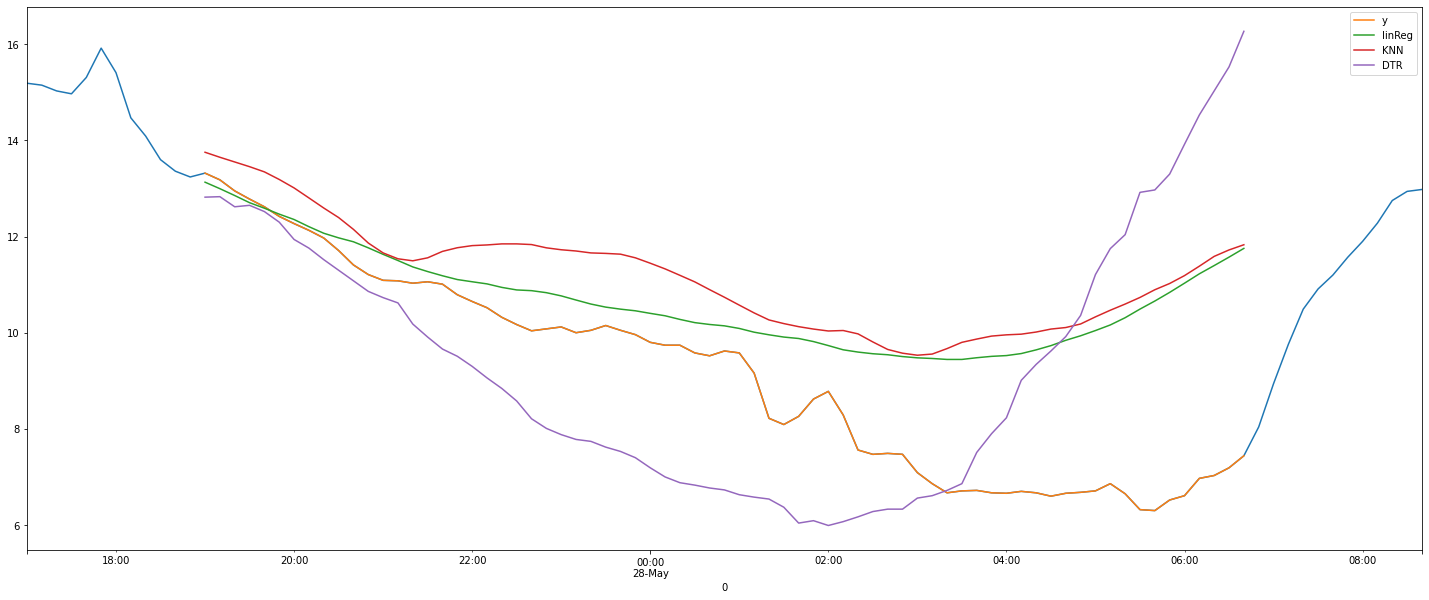

In [19]:
axis = raw_data["T (degC)"][x.index[0] - datetime.timedelta(hours=2):x.index[-1] + datetime.timedelta(hours=2)].plot()
x.plot(ax = axis,figsize=(25,10))
